In [231]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data and Preprocessing

#### 1. Loading Data

In [232]:
def load_data(file_url):
    with open('dataset.txt','wb') as f:
        content=requests.get(file_url,stream=True).content
        f.write(content)
    features,target=datasets.load_svmlight_file("dataset.txt")
    return features.toarray(),np.array(target)

In [233]:
## cleaned =https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
columns=['Pregnancies','Glucose','Blood Pressure','Skin Thickness','Insulin','BMI','Diabetes Pedigree','Age']
X,y=load_data('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes')


#### 2. EDA

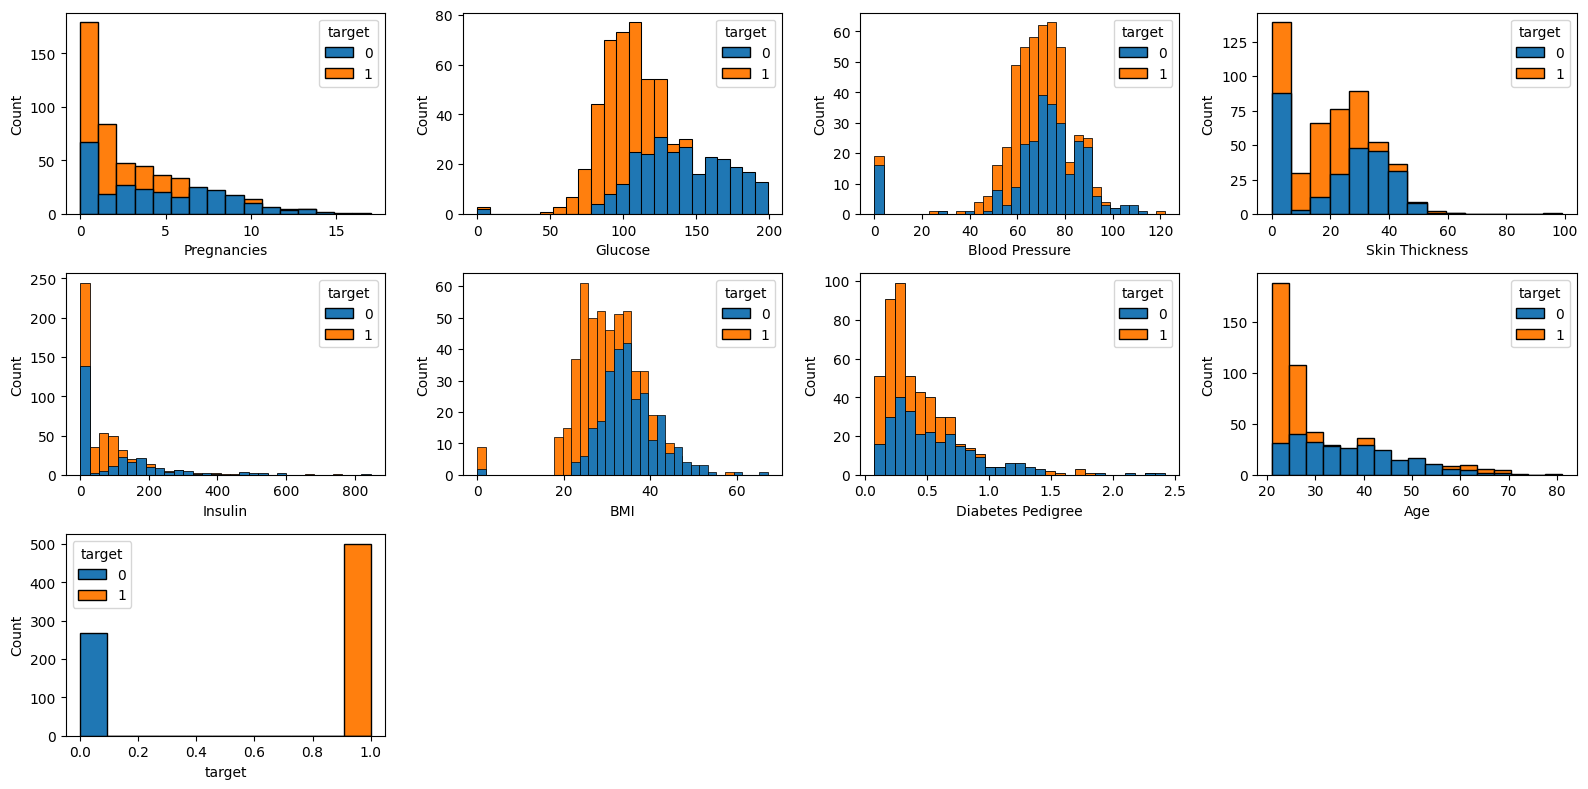

In [234]:
## general plotting of data based on the class to observe the distribution of the data.
df=pd.DataFrame(X,columns=columns)
df['target']=(y>0).astype(int)
fig,ax=plt.subplots(int(np.ceil(len(df.columns)/4)),4,figsize=(16,8))
for i in range(len(df.columns)):
    sns.histplot(data=df,x=df.columns[i],ax=ax[i//4,i%4],hue='target',alpha=1)

if((len(df.columns)%4)):
    for axes in ax.flatten()[(len(df.columns)%4)-4:]:
        fig.delaxes(axes)
plt.tight_layout()
plt.show()

#### 3. Preprocessing

In [235]:
## checking for nas or nulls
df.isna().sum()

Pregnancies          0
Glucose              0
Blood Pressure       0
Skin Thickness       0
Insulin              0
BMI                  0
Diabetes Pedigree    0
Age                  0
target               0
dtype: int64

## Base Model

In [236]:
import sklearn.metrics


class Perceptron:

    def __init__(self,X,y,split_ratio=[0.7,0.15,0.15],scaling=False,scaler=sklearn.preprocessing.StandardScaler,scale_range=(0,1)):
        self._X,self._y=X,y
        self._y=(self._y>0).astype(int)
        self.split(split_ratio)
        if(scaling):
            self.scale(scaler,scale_range)
        self._weights=np.zeros(len(self._X[0]))
        self._bias=0

        
    
    def split(self,split_ratio):
        
        self._X_train,X_rem,self._y_train,y_rem=train_test_split(self._X,self._y,train_size=split_ratio[0],stratify=self._y)
        self._X_val,self._X_test,self._y_val,self._y_test=train_test_split(X_rem,y_rem,train_size=split_ratio[1]/(split_ratio[1]+split_ratio[2]),stratify=y_rem)
        print('Splitted Data into Train,Val,Test with ratios:',split_ratio)
        print(np.array(self._X_train).shape,np.array(self._X_val).shape,np.array(self._X_test).shape,np.array(self._y_train).shape,np.array(self._y_val).shape,np.array(self._y_test).shape)
        
    def scale(self,scaler,scale_range):
        if(scaler==sklearn.preprocessing.StandardScaler):
            scaler_name=scaler.__name__
            scaler=scaler()
        if(scaler==sklearn.preprocessing.MinMaxScaler):
            scaler_name=scaler.__name__
            scaler=scaler(feature_range=scale_range)
        np.random.seed(42)
        self._X_train=scaler.fit_transform(self._X_train)
        self._X_val=scaler.transform(self._X_val)
        self._X_test=scaler.transform(self._X_test)
        print('Scaled data in range '+str(round(min(self._X_train.flatten()),4))+" , "+str(round(max(self._X_train.flatten()),4))+' using '+str(scaler_name))
    
    def sigmoid(self,x):
        return (1/(1+np.exp(-x)))
    
    def predict(self,input):
    
        return  np.round(0.5*(self.sigmoid(self._bias+np.sum(self._weights*input,axis=1))+1))
    
    def accuracy(self,true,pred):
        return round(sklearn.metrics.accuracy_score(true,pred),4)
    
    def f1(self,true,pred):
        return round(sklearn.metrics.f1_score(true,pred),4)
    
    def plot(self):
        plt.figure(figsize=(20,5))
        plt.plot(range(self._epochs),self._train_accuracy,label='train')
        plt.plot(range(self._epochs),self._val_accuracy,label='valid')
        plt.legend()
        plt.show()
    
    def lr_scheduler(self,lr,i,deacy_rate=0.001):
        return lr/(1+(deacy_rate*i))
    
    def train(self,epochs=100,batch_size=32,lr=1,decay=0,info=False):
        self._epochs=epochs
        self._train_accuracy=[]
        self._val_accuracy=[]
        for i in range(epochs):
            lr=self.lr_scheduler(lr,i,decay)
            index_list=list(range(0,len(self._X_train),batch_size))+[len(self._X_train)]
            for j in range(len(index_list)-1):
                
                preds=self.predict(self._X_train[index_list[j]:index_list[j+1],:])                
                error=np.sum(self._y_train[index_list[j]:index_list[j+1]]-preds)

                self._bias+=lr*error
                self._weights+=np.sum(lr*error*self._X_train[index_list[j]:index_list[j+1],:],axis=0)
            
            preds=self.predict(self._X_train)
            val_preds=self.predict(self._X_val)
            self._train_accuracy.append(self.accuracy(self._y_train,preds))
            self._val_accuracy.append(self.accuracy(self._y_val,val_preds))
            if(info):
                print('epoch '+str(i)+'- lr: '+str(round(lr,4)) +' train accuracy:'+str(self._train_accuracy[i])+", validation accuracy:  "+str(self._val_accuracy[i]))
                print('f1 scores: ',self.f1(self._y_train,preds),self.f1(self._y_val,val_preds))
        if(info):
            self.plot()

    def train_val(self):
        train_preds=self.predict(self._X_train)
        val_preds=self.predict(self._X_val)
        print('train accuracy:',self.accuracy(self._y_train,train_preds),',train f1score:',self.f1(self._y_train,train_preds))
        print('val accuracy:',self.accuracy(self._y_val,val_preds),',val f1score:',self.f1(self._y_val,val_preds))

    def test(self):
        test_preds=self.predict(self._X_test)
        print('test accuracy:',self.accuracy(self._y_test,test_preds),',test f1score:',self.f1(self._y_test,test_preds))
  


Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
epoch 0- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 1- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 2- lr: 1.0 train accuracy:0.5326, validation accuracy:  0.4957
f1 scores:  0.6133 0.5972
epoch 3- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 4- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 5- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 6- lr: 1.0 train accuracy:0.6518, validation accuracy:  0.6522
f1 scores:  0.7892 0.7895
epoch 7- lr: 1.0 train accuracy:0.6406, validation accuracy:  0.6609
f1 scores:  0.7666 0.7797
epoch 8- lr: 1.0 train accuracy:0.6499, validation accuracy:  0.6609
f1 scores:  0.7868 0.7937
epoch 9- lr: 1.0 train accuracy:

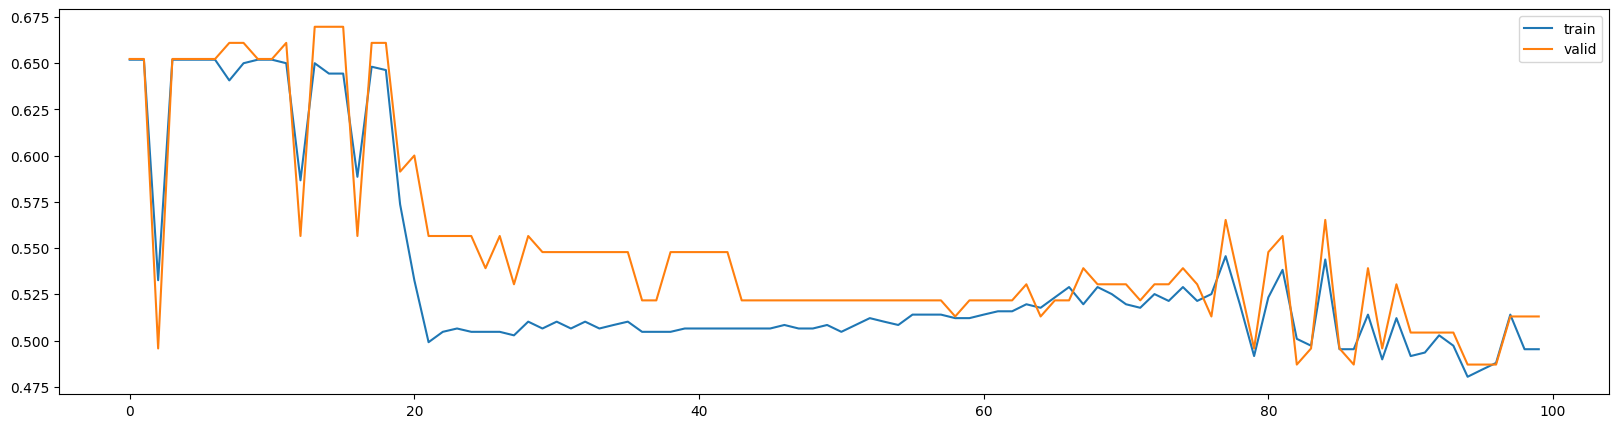

test accuracy: 0.4828 ,test f1score: 0.5833


In [237]:
## Base Model
perceptron=Perceptron(X,y)
#perceptron.train(batch_size=4,lr=0.01)
perceptron.train(info=True)
perceptron.test()

## Experimental Analysis

In [238]:
##Test for scaling
## Scaling always has better or same results
for scale in [False,True]:
    print('scaling:',scale)
    perceptron=Perceptron(X,y,scaling=scale)
    perceptron.train()
    perceptron.train_val()
    print()

scaling: False
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
train accuracy: 0.5196 ,train f1score: 0.6043
val accuracy: 0.513 ,val f1score: 0.6056

scaling: True
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -3.9972 , 5.8374 using StandardScaler
train accuracy: 0.6164 ,train f1score: 0.6979
val accuracy: 0.5565 ,val f1score: 0.6577



In [239]:
##Test for scaler
## My intuition was Minmaxscaler is better but Standardscaler is giving better results for this model.
for scaler in [sklearn.preprocessing.StandardScaler,sklearn.preprocessing.MinMaxScaler]:
    print('using:',scaler.__name__)
    perceptron=Perceptron(X,y,scaling=True,scaler=scaler,scale_range=(-1,1 ))
    perceptron.train()
    perceptron.train_val()
    print()

using: StandardScaler
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7132 ,train f1score: 0.7787
val accuracy: 0.687 ,val f1score: 0.7632

using: MinMaxScaler
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -1.0 , 1.0 using MinMaxScaler
train accuracy: 0.6462 ,train f1score: 0.75
val accuracy: 0.6261 ,val f1score: 0.7425



In [240]:
##Test for split ratio
## Some of the ratios that I usually use
for split in [[0.7,0.15,0.15],[0.7,0.2,0.1],[0.8,0.1,0.1]]:
    print('using:',split)
    perceptron=Perceptron(X,y,scaling=True,split_ratio=split,scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train()
    perceptron.train_val()
    print()

using: [0.7, 0.15, 0.15]
Splitted Data into Train,Val,Test with ratios: [0.7, 0.15, 0.15]
(537, 8) (115, 8) (116, 8) (537,) (115,) (116,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7132 ,train f1score: 0.7787
val accuracy: 0.687 ,val f1score: 0.7632

using: [0.7, 0.2, 0.1]
Splitted Data into Train,Val,Test with ratios: [0.7, 0.2, 0.1]
(537, 8) (154, 8) (77, 8) (537,) (154,) (77,)
Scaled data in range -4.0237 , 5.8372 using StandardScaler
train accuracy: 0.7132 ,train f1score: 0.7787
val accuracy: 0.6494 ,val f1score: 0.73

using: [0.8, 0.1, 0.1]
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7085 ,train f1score: 0.7678
val accuracy: 0.7403 ,val f1score: 0.7917



In [276]:
##Test for epochs
## Since this is a simpler model mroe epochs might not be that useful
for epochs in [25,50,100]:
    print('using:',epochs)
    perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(epochs=epochs)
    perceptron.train_val()
    print()

using: 25
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7101 ,train f1score: 0.77
val accuracy: 0.7273 ,val f1score: 0.7835

using: 50
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7052 ,train f1score: 0.7671
val accuracy: 0.7143 ,val f1score: 0.7708

using: 100
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7085 ,train f1score: 0.7678
val accuracy: 0.7403 ,val f1score: 0.7917



In [283]:
##Test for batchsize
## Some batchsize used generally
for batch in [4,8,16,32,64]:
    print('using:',batch)
    perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
    perceptron.train(batch_size=batch,epochs=100)
    perceptron.train_val()
    print()

using: 4
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7378 ,train f1score: 0.8034
val accuracy: 0.6234 ,val f1score: 0.729

using: 8
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7199 ,train f1score: 0.7823
val accuracy: 0.6234 ,val f1score: 0.7339

using: 16
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.6645 ,train f1score: 0.7425
val accuracy: 0.5974 ,val f1score: 0.7048

using: 32
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7085 ,train f1

In [287]:
##Test for lr
## Some learning rates that I usually start to test with
for learning_rate in [1,1e-1,1e-2,1e-3]:
    print('using:',learning_rate)
    perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler,scale_range=(-1,1))
    perceptron.train(epochs=100,lr=learning_rate,batch_size=32)
    perceptron.train_val()
    print()

using: 1
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7085 ,train f1score: 0.7678
val accuracy: 0.7403 ,val f1score: 0.7917

using: 0.1
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7215 ,train f1score: 0.7794
val accuracy: 0.7273 ,val f1score: 0.7879

using: 0.01
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7199 ,train f1score: 0.7784
val accuracy: 0.7273 ,val f1score: 0.7835

using: 0.001
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7068 ,

In [294]:
##Test for lr decay , since 1,0.1 and 0.01 gave similar results testing with all
for lr in [1,1e-1,1e-2]:
    for decay in [0,1e-1,1e-2,1e-3]:
        print('using lr:',lr,'and decay:',decay)
        perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
        perceptron.train(epochs=500,lr=1,batch_size=32,decay=decay)
        perceptron.train_val()
        print()

using lr: 1 and decay: 0
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7182 ,train f1score: 0.7768
val accuracy: 0.7403 ,val f1score: 0.7917

using lr: 1 and decay: 0.1
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7182 ,train f1score: 0.7768
val accuracy: 0.7532 ,val f1score: 0.7957

using lr: 1 and decay: 0.01
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7085 ,train f1score: 0.7696
val accuracy: 0.7273 ,val f1score: 0.7789

using lr: 1 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in rang

using lr: 1 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
epoch 0- lr: 1.0 train accuracy:0.6287, validation accuracy:  0.6104
f1 scores:  0.7016 0.7115
epoch 1- lr: 0.9091 train accuracy:0.6824, validation accuracy:  0.6753
f1 scores:  0.7477 0.7619
epoch 2- lr: 0.7576 train accuracy:0.7036, validation accuracy:  0.7403
f1 scores:  0.7636 0.7959
epoch 3- lr: 0.5828 train accuracy:0.7117, validation accuracy:  0.7532
f1 scores:  0.7704 0.8041
epoch 4- lr: 0.4163 train accuracy:0.7182, validation accuracy:  0.7662
f1 scores:  0.7756 0.8125
epoch 5- lr: 0.2775 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 6- lr: 0.1734 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 7- lr: 0.102 train accuracy:0.7215, validation accuracy:  0.7532
f1 scores:  0.7794 0.7957
epoch 8- lr: 0.0567 train

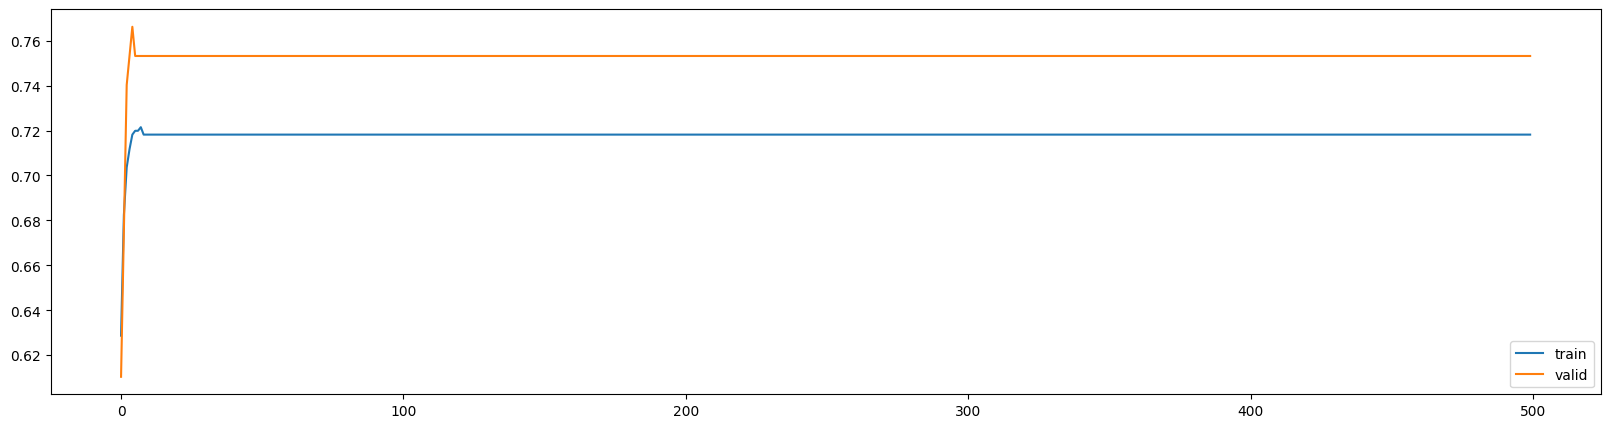

train accuracy: 0.7182 ,train f1score: 0.7768
val accuracy: 0.7532 ,val f1score: 0.7957

using lr: 0.1 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
epoch 0- lr: 1.0 train accuracy:0.6287, validation accuracy:  0.6104
f1 scores:  0.7016 0.7115
epoch 1- lr: 0.9091 train accuracy:0.6824, validation accuracy:  0.6753
f1 scores:  0.7477 0.7619
epoch 2- lr: 0.7576 train accuracy:0.7036, validation accuracy:  0.7403
f1 scores:  0.7636 0.7959
epoch 3- lr: 0.5828 train accuracy:0.7117, validation accuracy:  0.7532
f1 scores:  0.7704 0.8041
epoch 4- lr: 0.4163 train accuracy:0.7182, validation accuracy:  0.7662
f1 scores:  0.7756 0.8125
epoch 5- lr: 0.2775 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 6- lr: 0.1734 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 7- lr: 0.102 train accura

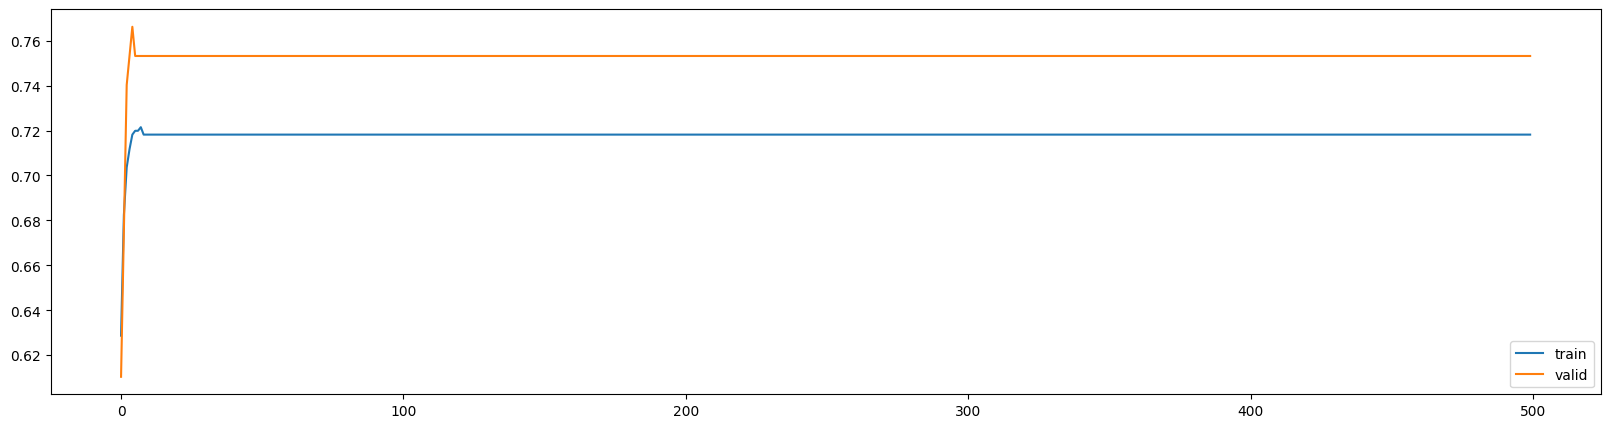

train accuracy: 0.7182 ,train f1score: 0.7768
val accuracy: 0.7532 ,val f1score: 0.7957

using lr: 0.01 and decay: 0.001
Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
epoch 0- lr: 1.0 train accuracy:0.6287, validation accuracy:  0.6104
f1 scores:  0.7016 0.7115
epoch 1- lr: 0.9091 train accuracy:0.6824, validation accuracy:  0.6753
f1 scores:  0.7477 0.7619
epoch 2- lr: 0.7576 train accuracy:0.7036, validation accuracy:  0.7403
f1 scores:  0.7636 0.7959
epoch 3- lr: 0.5828 train accuracy:0.7117, validation accuracy:  0.7532
f1 scores:  0.7704 0.8041
epoch 4- lr: 0.4163 train accuracy:0.7182, validation accuracy:  0.7662
f1 scores:  0.7756 0.8125
epoch 5- lr: 0.2775 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 6- lr: 0.1734 train accuracy:0.7199, validation accuracy:  0.7532
f1 scores:  0.7778 0.7957
epoch 7- lr: 0.102 train accur

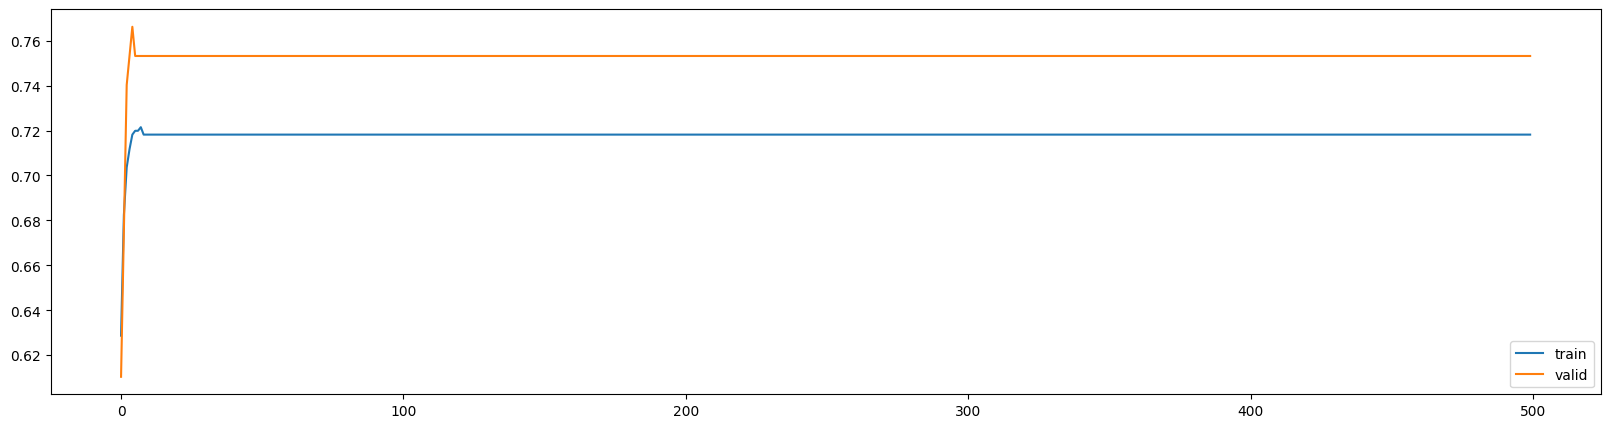

train accuracy: 0.7182 ,train f1score: 0.7768
val accuracy: 0.7532 ,val f1score: 0.7957



In [295]:
## since (lr,decay) of (1,0.1),(0.1,0.1),(0.01,0.1) are giving same results choosing better one from Graph
for lr in [1,1e-1,1e-2]:
        print('using lr:',lr,'and decay:',decay)
        perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
        perceptron.train(epochs=500,lr=1,batch_size=32,decay=0.1,info=True)
        perceptron.train_val()
        print()

**From the above experimental test, best model parameters are:**
* scaling: True
* scaler: Standard
* epochs=100
* lr=0.01
* batch_size=32
* decay=0.1

since all of the last 3 models are having same performance results choosing the one with learning rate as 0.1 as it has balance and deacy of learning rate, choosing the lesser learning rate one might decay too soon and the higher one might overshoot, if more data were to be added.

## Testing Performance of the best Model

In [306]:
## Best Model
perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(epochs=100,lr=0.01,batch_size=32,decay=0.1)
perceptron.train_val()
perceptron.test()

Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.684 ,train f1score: 0.8016
val accuracy: 0.6494 ,val f1score: 0.7805
test accuracy: 0.6753 ,test f1score: 0.8


In [308]:
## Best Model
## upon some more experimentation, I got better result with bathcsize 4, then changed the lr and decay respectively
perceptron=Perceptron(X,y,scaling=True,split_ratio=[0.8, 0.1, 0.1],scaler=sklearn.preprocessing.StandardScaler)
perceptron.train(epochs=100,lr=0.001,batch_size=4,decay=0.00)
perceptron.train_val()
perceptron.test()

Splitted Data into Train,Val,Test with ratios: [0.8, 0.1, 0.1]
(614, 8) (77, 8) (77, 8) (614,) (77,) (77,)
Scaled data in range -3.9879 , 6.4266 using StandardScaler
train accuracy: 0.7492 ,train f1score: 0.8289
val accuracy: 0.6623 ,val f1score: 0.7833
test accuracy: 0.7403 ,test f1score: 0.8276
